# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Transition with anticipated and delayed monetary policy responses

This notebook does the following:
1. It computes the transition to the new steady state for different timings of a reaction of the central bank. There is an anticipated fiscal expansion starting at $t=12$. We analyze three alternatives:
   - The central bank reacts immediately (at $t=0$)
   - The central bank reacts when the fiscal expansion occurs (at $t=12$)
   - The central bank reacts after the fiscal expansion starts (at $t=24$)
3. It saves the impulse response functions for these cases in `irfs/irf_forward.json`, `irfs/irf_coincident.json`, and `irfs/irf_delayed.json`.
4. It produces Figure 7 in the paper.
5. It produces the welfare calculations reported in Table 5 in the paper

### Requirements
The code requires that the files `irfs/irf_baseline.json`, `ss/ss_hank_ini.json` and `ss/ss_hank_end.json` exist. It imports the model from the file `model.py` and various functions from `utils.py`. The code is othwerwise self-contained.

In [25]:
# Standard imports
import json
import os
import numpy as np
import pandas as pd

# Other imports
import sequence_jacobian as sj

from model import hank_lb
from utils import rebase_irf, plot_irfs, plot_residuals, is_residual

In [2]:
def calculate_welfare(ss_ini, ss_end, irf_r):
    
    T = len(irf_r['C'])
    # Initial SS
    c_ss_ini = ss_ini.internals['hh']['c']
    D_ss_ini = ss_ini.internals['hh']['D']
    u_ss_ini = np.log(c_ss_ini)
    Eu_of_c_ss_ini = np.sum(D_ss_ini * u_ss_ini)

    vphi = ss_ini['vphi']
    frisch = ss_ini['frisch']
    n_ss_ini = ss_ini['N']
    v_of_n_ss_ini = vphi * n_ss_ini ** (1 + 1 / frisch)

    Eu_ss_ini = Eu_of_c_ss_ini - v_of_n_ss_ini
    
    
    # Final SS
    c_ss_end = ss_end.internals['hh']['c']
    D_ss_end = ss_end.internals['hh']['D']
    u_ss_end = np.log(c_ss_end)
    Eu_of_c_ss_end = np.sum(D_ss_end * u_ss_end)

    n_ss_end = ss_end['N']
    v_of_n_ss_end = vphi * n_ss_end ** (1 + 1 / frisch)

    Eu_ss_end = Eu_of_c_ss_end - v_of_n_ss_end
    
    # Transition
    # Utility of consumption
    c_ss = ss_end.internals['hh']['c']
    D_ss = ss_end.internals['hh']['D']
    dc = irf_r.internals['hh']['c']
    c = dc + c_ss[np.newaxis, :, :, :]
    dD = irf_r.internals['hh']['D']
    D = dD + D_ss[np.newaxis, :, :, :]
    u = np.log(c)

    # Sum the elementwise product along the non-time dimensions (1, 2, and 3)
    Eu_of_c = np.sum(D * u, axis=(1, 2, 3))

    # Disutility of employment - same for all agents
    n = irf_r['N'] + ss_end['N']
    v_of_n = vphi * n ** (1 + 1 / frisch)

    Eu = Eu_of_c - v_of_n

    
    # Lifetime welfare
    beta = ss_ini['beta']
    W_ss_ini = Eu_ss_ini / (1-beta)
    #W_ss_ini_alt = np.sum([beta**t * Eu_ss_ini for t in range(len(Eu))]) + beta**T * Eu_ss_ini / (1-beta)
    W_transition = np.sum([beta**t * Eu[t] for t in range(T)]) + beta**T * Eu_ss_end / (1-beta)

    dW_transition = W_transition - W_ss_ini # This is log(1 + lambda) / (1-beta)
    lam_W_transition = 100 * (np.exp((1-beta) * dW_transition) - 1)  # Consumption-equivalent loss of lifetime utility function

     
    W_ss_end = Eu_ss_end / (1-beta)
    dW = W_ss_end - W_ss_ini # This is log(1 + lambda) / (1-beta)
    lam_W = 100 * (np.exp((1-beta) * dW) - 1)  # Consumption-equivalent loss of lifetime utility function

    return lam_W_transition, lam_W

In [3]:
print("\n")
print("=" *80)
print(f"The {hank_lb.name} model")
print("=" *80)
print(*hank_lb.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_lb.name} has inputs{hank_lb.inputs}")
print("-" * 80)
print(f"The {hank_lb.name} has outputs {hank_lb.outputs}")



The Baseline Two-Asset HANK model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Baseline Two-Asset HANK has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'delta_lb']
--------------------------------------------------------------------------------
The Baseline Two-Asset HANK has outputs ['A', 'B', 'C

In [4]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_lb.steady_state(data, dissolve=[
    'taylor_smooth',
    'G_rule',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_lb.steady_state(data, dissolve=[
    'taylor_smooth',
    'G_rule',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.0

In [5]:
# Initialize dictionary for welfare
welfare = dict()

## 1. Monetary policy reacts at t = 0

In [6]:
T = 300
H = 12

vec = np.hstack([np.zeros(H), np.ones(T-H)])


drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) *  vec
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * vec

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_lb_r =  hank_lb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini, internals=['hh'])

Solving Baseline Two-Asset HANK for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   max erro

On iteration 1
   max error for asset_mkt is 9.00E-03
   max error for wnkpc_res is 2.03E-04
   max error for rpost_res is 3.06E-04
   max error for bond_mkt is 8.46E-03
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.31E-03
On iteration 1
   max error for inv_res is 2.89E-04
   max error for val_res is 6.66E-06
On iteration 2
   max error for inv_res is 1.46E-06
   max error for val_res is 2.23E-08
On iteration 3
   max error for inv_res is 7.28E-09
   max error for val_res is 1.72E-10
On iteration 4
   max error for inv_res is 3.69E-11
   max error for val_res is 4.08E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.75E-04
On iteration 1
   max error for nkpc_res is 2.05E-04
On iteration 2
   max error for nkpc_res is 1.60E-06
On iteration 3
   max error for nkpc_res is 1.82E-08
On iteration 4
   max error for

On iteration 3
   max error for asset_mkt is 9.34E-05
   max error for wnkpc_res is 1.27E-06
   max error for rpost_res is 1.53E-05
   max error for bond_mkt is 8.88E-05
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.33E-03
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 6.92E-06
On iteration 2
   max error for inv_res is 1.46E-06
   max error for val_res is 2.24E-08
On iteration 3
   max error for inv_res is 7.27E-09
   max error for val_res is 1.64E-10
On iteration 4
   max error for inv_res is 3.68E-11
   max error for val_res is 3.90E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.07E-04
On iteration 2
   max error for nkpc_res is 1.61E-06
On iteration 3
   max error for nkpc_res is 1.90E-08
On iteration 4
   max error for

On iteration 5
   max error for asset_mkt is 1.43E-06
   max error for wnkpc_res is 1.25E-08
   max error for rpost_res is 2.59E-07
   max error for bond_mkt is 1.26E-06
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.33E-03
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 6.92E-06
On iteration 2
   max error for inv_res is 1.46E-06
   max error for val_res is 2.24E-08
On iteration 3
   max error for inv_res is 7.27E-09
   max error for val_res is 1.64E-10
On iteration 4
   max error for inv_res is 3.68E-11
   max error for val_res is 3.89E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.07E-04
On iteration 2
   max error for nkpc_res is 1.61E-06
On iteration 3
   max error for nkpc_res is 1.90E-08
On iteration 4
   max error for

On iteration 7
   max error for asset_mkt is 2.24E-08
   max error for wnkpc_res is 1.55E-10
   max error for rpost_res is 4.06E-09
   max error for bond_mkt is 1.95E-08
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.33E-03
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 6.92E-06
On iteration 2
   max error for inv_res is 1.46E-06
   max error for val_res is 2.24E-08
On iteration 3
   max error for inv_res is 7.27E-09
   max error for val_res is 1.64E-10
On iteration 4
   max error for inv_res is 3.68E-11
   max error for val_res is 3.89E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.07E-04
On iteration 2
   max error for nkpc_res is 1.61E-06
On iteration 3
   max error for nkpc_res is 1.90E-08
On iteration 4
   max error for

On iteration 9
   max error for asset_mkt is 3.50E-10
   max error for wnkpc_res is 2.24E-12
   max error for rpost_res is 6.29E-11
   max error for bond_mkt is 3.04E-10
On iteration 9
   max error for asset_mkt is 3.50E-10
   max error for wnkpc_res is 2.24E-12
   max error for rpost_res is 6.29E-11
   max error for bond_mkt is 3.04E-10


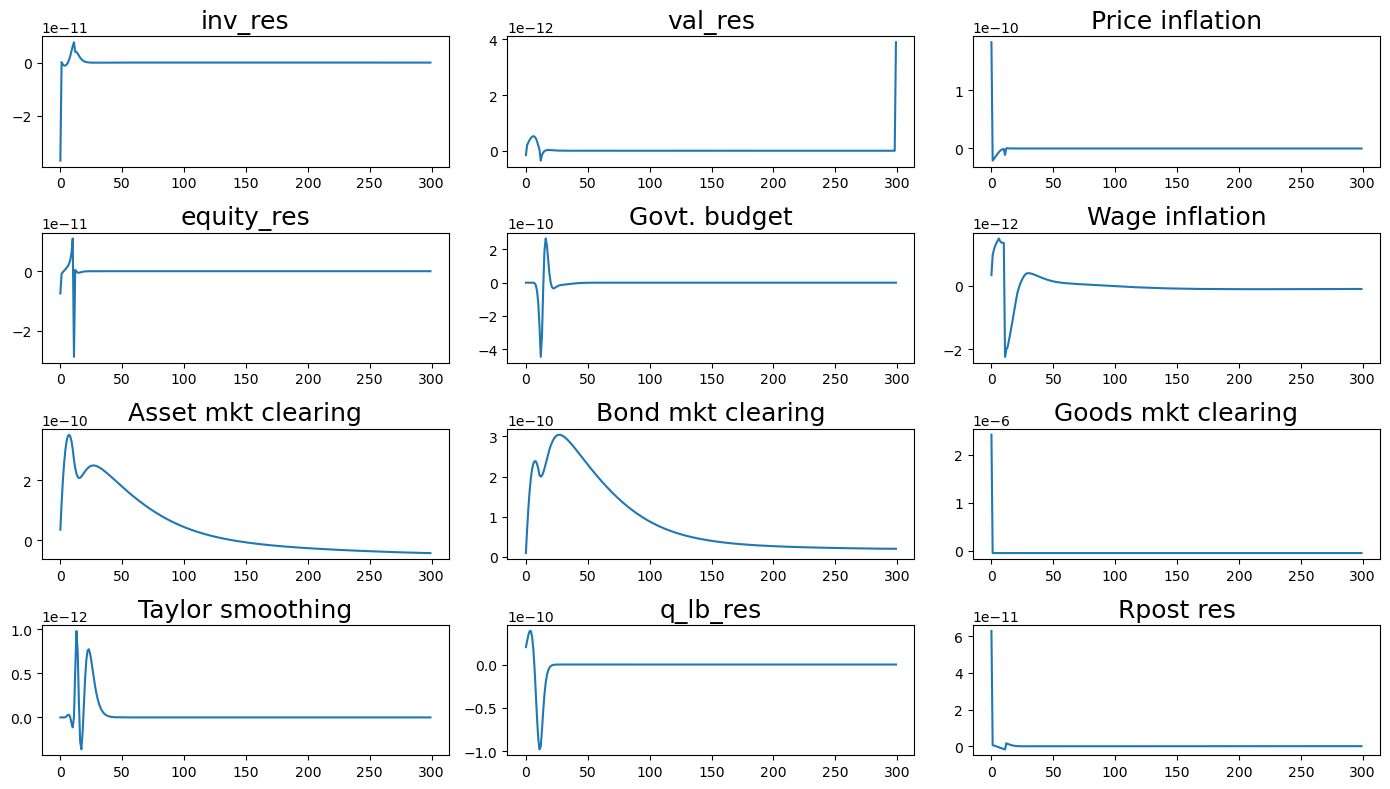

In [8]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r, hank_lb_residuals)

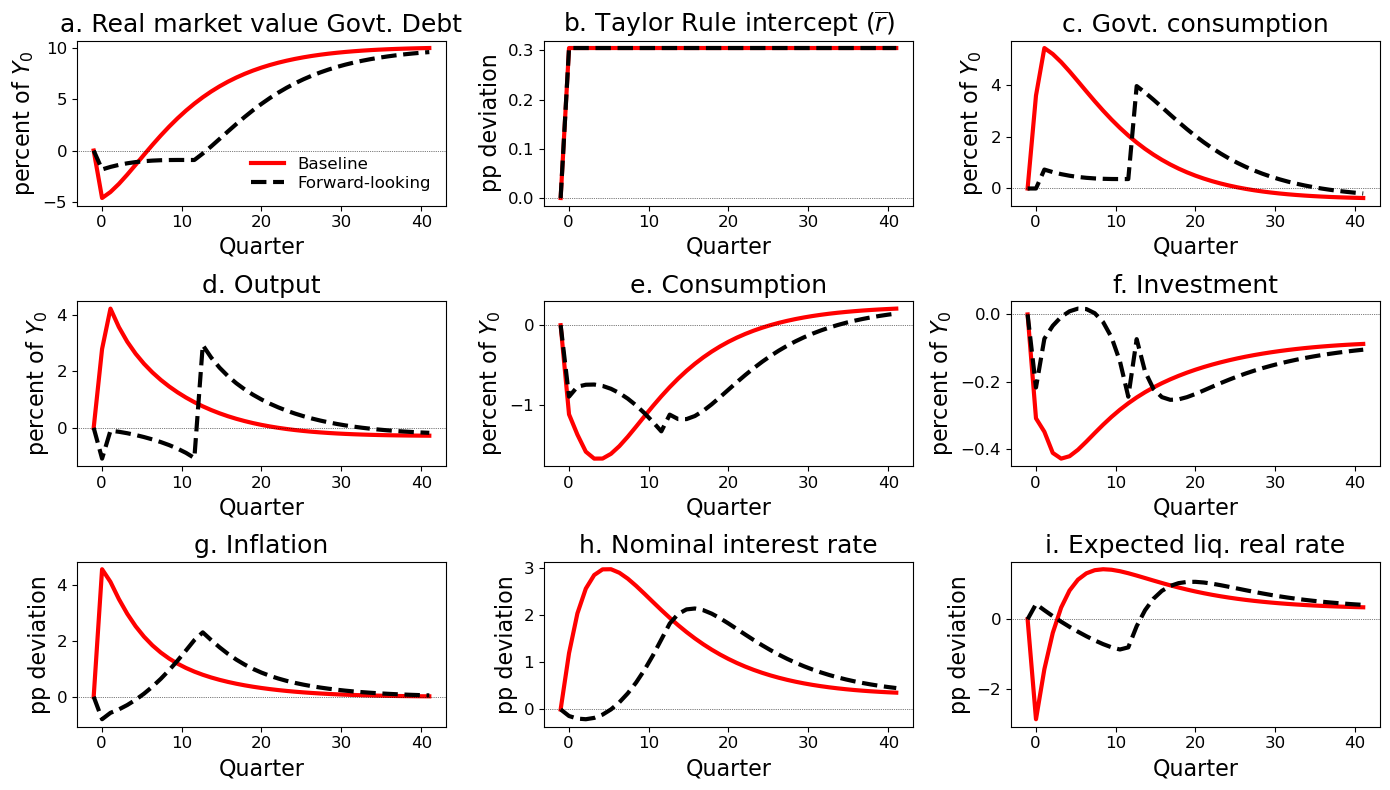

In [10]:
irf_hank_lb = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_lb_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'Forward-looking': irf_hank_lb}
plot_cases = ['Baseline', 'Forward-looking']
save_name = None
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [11]:
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_lb, open(os.path.join("irfs", "irf_forward.json"), 'w'), cls=NumpyEncoder, indent=4)

In [12]:
welfare['Forward-looking'] = calculate_welfare(ss_hank_ini, ss_hank_end, irf_hank_lb_r)
welfare

{'Forward-looking': (np.float64(0.009515468931131643),
  np.float64(0.8002348627807798))}

## 2. Monetary policy reacts at t = 12

In [13]:
T = 300
H = 12

vec = np.hstack([np.zeros(H), np.ones(T-H)])


drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) *  vec
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) *  vec
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * vec

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_lb_r =  hank_lb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini, internals=['hh'])

Solving Baseline Two-Asset HANK for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   max erro

On iteration 1
   max error for asset_mkt is 1.01E-02
   max error for wnkpc_res is 2.09E-04
   max error for rpost_res is 5.69E-04
   max error for bond_mkt is 1.09E-02
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.24E-03
On iteration 1
   max error for inv_res is 2.96E-04
   max error for val_res is 5.86E-06
On iteration 2
   max error for inv_res is 1.45E-06
   max error for val_res is 2.05E-08
On iteration 3
   max error for inv_res is 7.19E-09
   max error for val_res is 1.78E-10
On iteration 4
   max error for inv_res is 3.61E-11
   max error for val_res is 4.23E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 7.90E-04
On iteration 1
   max error for nkpc_res is 2.14E-04
On iteration 2
   max error for nkpc_res is 1.69E-06
On iteration 3
   max error for nkpc_res is 2.10E-08
On iteration 4
   max error for

On iteration 3
   max error for asset_mkt is 9.38E-05
   max error for wnkpc_res is 1.41E-06
   max error for rpost_res is 2.23E-05
   max error for bond_mkt is 1.20E-04
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.26E-03
On iteration 1
   max error for inv_res is 2.96E-04
   max error for val_res is 5.95E-06
On iteration 2
   max error for inv_res is 1.45E-06
   max error for val_res is 2.08E-08
On iteration 3
   max error for inv_res is 7.18E-09
   max error for val_res is 1.68E-10
On iteration 4
   max error for inv_res is 3.60E-11
   max error for val_res is 3.99E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 7.94E-04
On iteration 1
   max error for nkpc_res is 2.15E-04
On iteration 2
   max error for nkpc_res is 1.69E-06
On iteration 3
   max error for nkpc_res is 2.20E-08
On iteration 4
   max error for

On iteration 5
   max error for asset_mkt is 1.26E-06
   max error for wnkpc_res is 1.43E-08
   max error for rpost_res is 3.92E-07
   max error for bond_mkt is 1.73E-06
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.26E-03
On iteration 1
   max error for inv_res is 2.96E-04
   max error for val_res is 5.95E-06
On iteration 2
   max error for inv_res is 1.45E-06
   max error for val_res is 2.08E-08
On iteration 3
   max error for inv_res is 7.18E-09
   max error for val_res is 1.68E-10
On iteration 4
   max error for inv_res is 3.60E-11
   max error for val_res is 3.98E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 7.94E-04
On iteration 1
   max error for nkpc_res is 2.15E-04
On iteration 2
   max error for nkpc_res is 1.69E-06
On iteration 3
   max error for nkpc_res is 2.20E-08
On iteration 4
   max error for

On iteration 7
   max error for asset_mkt is 1.91E-08
   max error for wnkpc_res is 2.28E-10
   max error for rpost_res is 6.25E-09
   max error for bond_mkt is 2.67E-08
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.26E-03
On iteration 1
   max error for inv_res is 2.96E-04
   max error for val_res is 5.95E-06
On iteration 2
   max error for inv_res is 1.45E-06
   max error for val_res is 2.08E-08
On iteration 3
   max error for inv_res is 7.18E-09
   max error for val_res is 1.68E-10
On iteration 4
   max error for inv_res is 3.60E-11
   max error for val_res is 3.98E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 7.94E-04
On iteration 1
   max error for nkpc_res is 2.15E-04
On iteration 2
   max error for nkpc_res is 1.69E-06
On iteration 3
   max error for nkpc_res is 2.20E-08
On iteration 4
   max error for

On iteration 9
   max error for asset_mkt is 2.97E-10
   max error for wnkpc_res is 3.59E-12
   max error for rpost_res is 9.78E-11
   max error for bond_mkt is 4.16E-10
On iteration 9
   max error for asset_mkt is 2.97E-10
   max error for wnkpc_res is 3.59E-12
   max error for rpost_res is 9.78E-11
   max error for bond_mkt is 4.16E-10


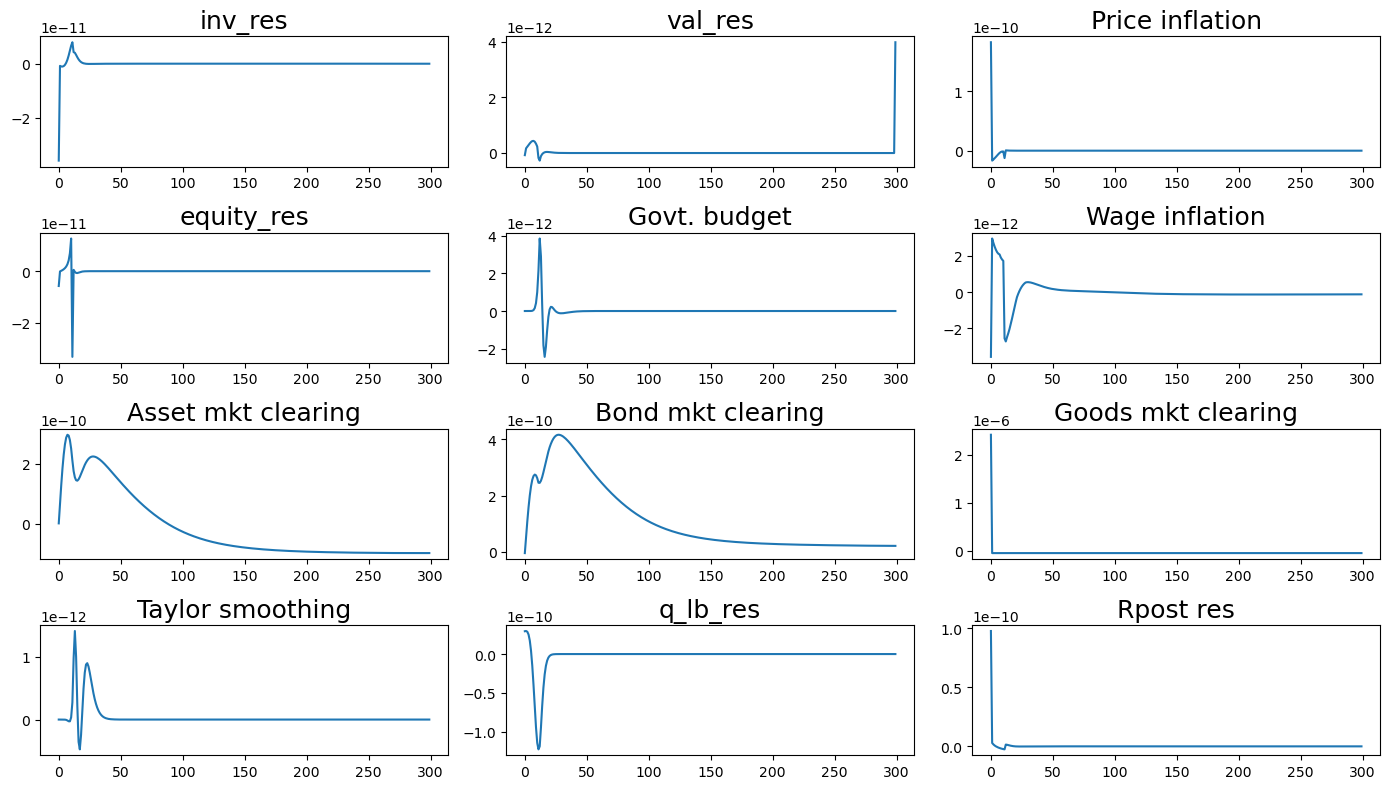

In [14]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r, hank_lb_residuals)

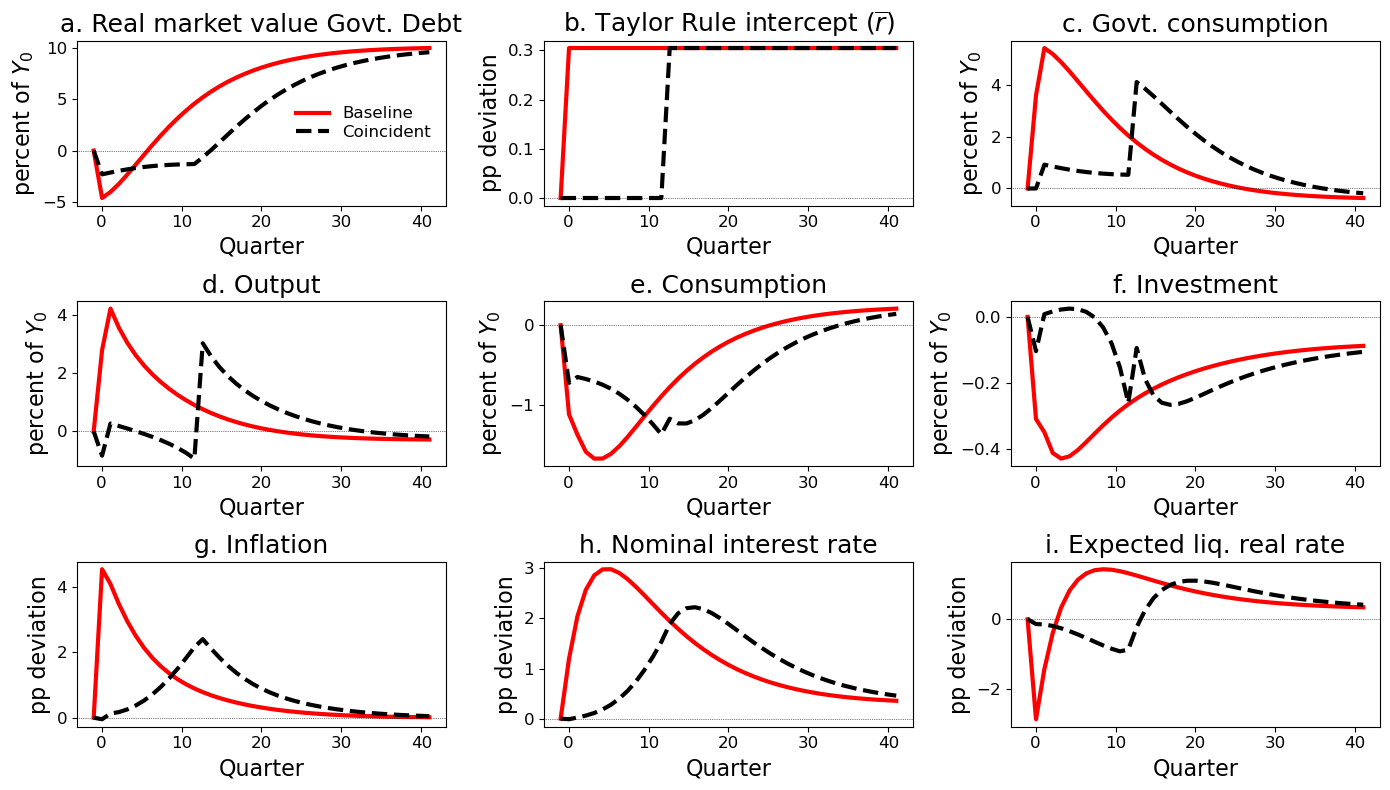

In [15]:
irf_hank_lb = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_lb_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'Coincident': irf_hank_lb}
plot_cases = ['Baseline', 'Coincident']
save_name = None
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [16]:
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_lb, open(os.path.join("irfs", "irf_coincident.json"), 'w'), cls=NumpyEncoder, indent=4)

In [17]:
welfare['Coincident'] = calculate_welfare(ss_hank_ini, ss_hank_end, irf_hank_lb_r)
welfare

{'Forward-looking': (np.float64(0.009515468931131643),
  np.float64(0.8002348627807798)),
 'Coincident': (np.float64(-0.05569040162084482),
  np.float64(0.8002348627807798))}

## 3. Monetary policy reacts at t = 24

In [18]:
T = 300
H = 12
H_mp = 24

vec = np.hstack([np.zeros(H), np.ones(T-H)])
vec_mp = np.hstack([np.zeros(H_mp), np.ones(T-H_mp)])

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) *  vec_mp
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) *  vec
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * vec

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_lb_r =  hank_lb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini, internals=['hh'])

Solving Baseline Two-Asset HANK for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   max erro

On iteration 1
   max error for asset_mkt is 9.62E-03
   max error for wnkpc_res is 2.46E-04
   max error for rpost_res is 1.78E-03
   max error for bond_mkt is 1.39E-02
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.18E-03
On iteration 1
   max error for inv_res is 2.98E-04
   max error for val_res is 7.48E-06
On iteration 2
   max error for inv_res is 1.44E-06
   max error for val_res is 1.78E-08
On iteration 3
   max error for inv_res is 6.98E-09
   max error for val_res is 1.94E-10
On iteration 4
   max error for inv_res is 3.48E-11
   max error for val_res is 4.59E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.76E-04
On iteration 1
   max error for nkpc_res is 2.52E-04
On iteration 2
   max error for nkpc_res is 1.95E-06
On iteration 3
   max error for nkpc_res is 3.50E-08
On iteration 4
   max error for

On iteration 3
   max error for asset_mkt is 8.66E-05
   max error for wnkpc_res is 3.04E-06
   max error for rpost_res is 4.80E-05
   max error for bond_mkt is 1.94E-04
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.22E-03
On iteration 1
   max error for inv_res is 2.99E-04
   max error for val_res is 7.62E-06
On iteration 2
   max error for inv_res is 1.44E-06
   max error for val_res is 1.83E-08
On iteration 3
   max error for inv_res is 6.99E-09
   max error for val_res is 1.84E-10
On iteration 4
   max error for inv_res is 3.47E-11
   max error for val_res is 4.35E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.53E-04
On iteration 2
   max error for nkpc_res is 1.95E-06
On iteration 3
   max error for nkpc_res is 3.63E-08
On iteration 4
   max error for

On iteration 5
   max error for asset_mkt is 1.45E-06
   max error for wnkpc_res is 6.02E-08
   max error for rpost_res is 9.68E-07
   max error for bond_mkt is 3.33E-06
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.22E-03
On iteration 1
   max error for inv_res is 2.99E-04
   max error for val_res is 7.62E-06
On iteration 2
   max error for inv_res is 1.44E-06
   max error for val_res is 1.83E-08
On iteration 3
   max error for inv_res is 6.99E-09
   max error for val_res is 1.84E-10
On iteration 4
   max error for inv_res is 3.47E-11
   max error for val_res is 4.35E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.53E-04
On iteration 2
   max error for nkpc_res is 1.95E-06
On iteration 3
   max error for nkpc_res is 3.63E-08
On iteration 4
   max error for

On iteration 7
   max error for asset_mkt is 2.67E-08
   max error for wnkpc_res is 1.12E-09
   max error for rpost_res is 1.80E-08
   max error for bond_mkt is 6.00E-08
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.22E-03
On iteration 1
   max error for inv_res is 2.99E-04
   max error for val_res is 7.62E-06
On iteration 2
   max error for inv_res is 1.44E-06
   max error for val_res is 1.83E-08
On iteration 3
   max error for inv_res is 6.99E-09
   max error for val_res is 1.84E-10
On iteration 4
   max error for inv_res is 3.47E-11
   max error for val_res is 4.35E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.53E-04
On iteration 2
   max error for nkpc_res is 1.95E-06
On iteration 3
   max error for nkpc_res is 3.63E-08
On iteration 4
   max error for

On iteration 9
   max error for asset_mkt is 4.86E-10
   max error for wnkpc_res is 2.04E-11
   max error for rpost_res is 3.30E-10
   max error for bond_mkt is 1.09E-09
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 2.22E-03
On iteration 1
   max error for inv_res is 2.99E-04
   max error for val_res is 7.62E-06
On iteration 2
   max error for inv_res is 1.44E-06
   max error for val_res is 1.83E-08
On iteration 3
   max error for inv_res is 6.99E-09
   max error for val_res is 1.84E-10
On iteration 4
   max error for inv_res is 3.47E-11
   max error for val_res is 4.35E-12
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 8.79E-04
On iteration 1
   max error for nkpc_res is 2.53E-04
On iteration 2
   max error for nkpc_res is 1.95E-06
On iteration 3
   max error for nkpc_res is 3.63E-08
On iteration 4
   max error for

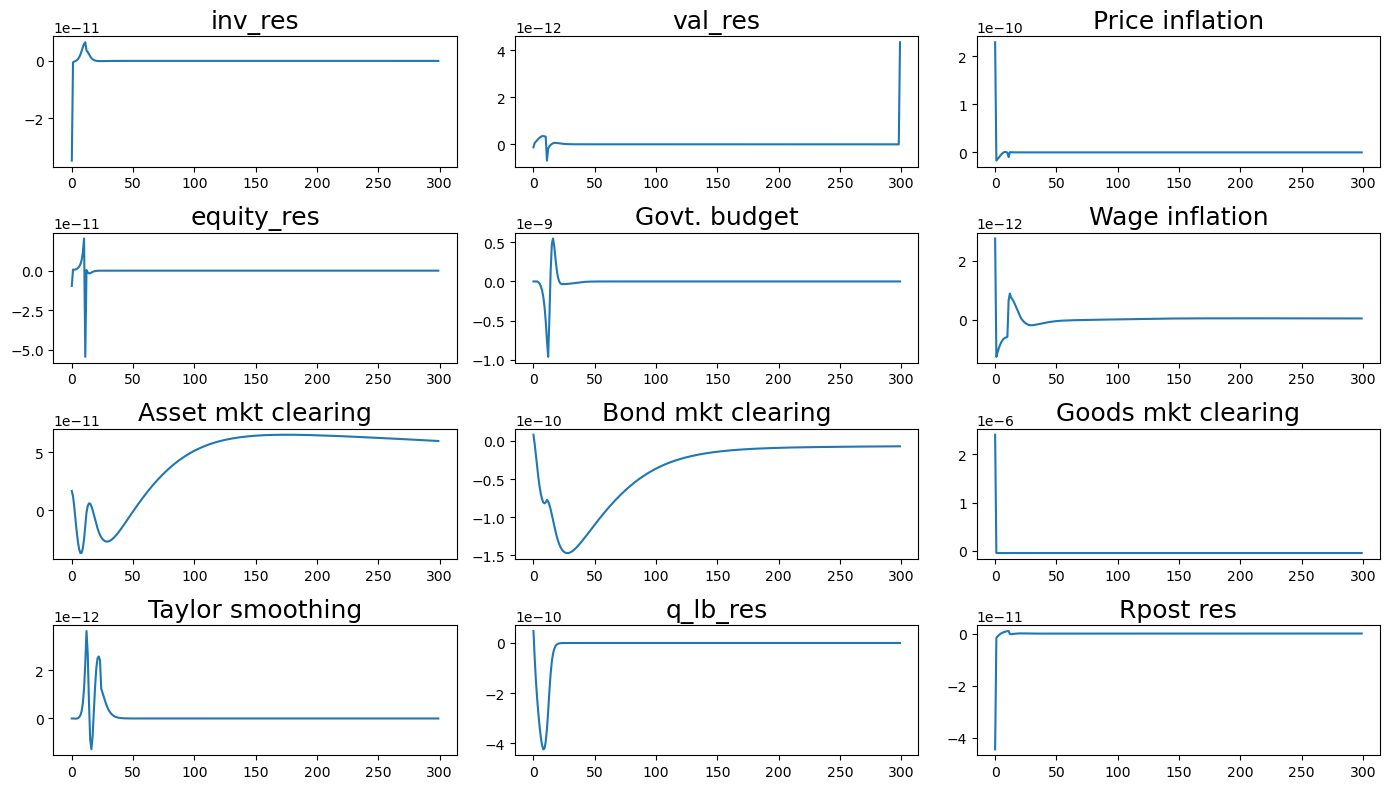

In [19]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r, hank_lb_residuals)

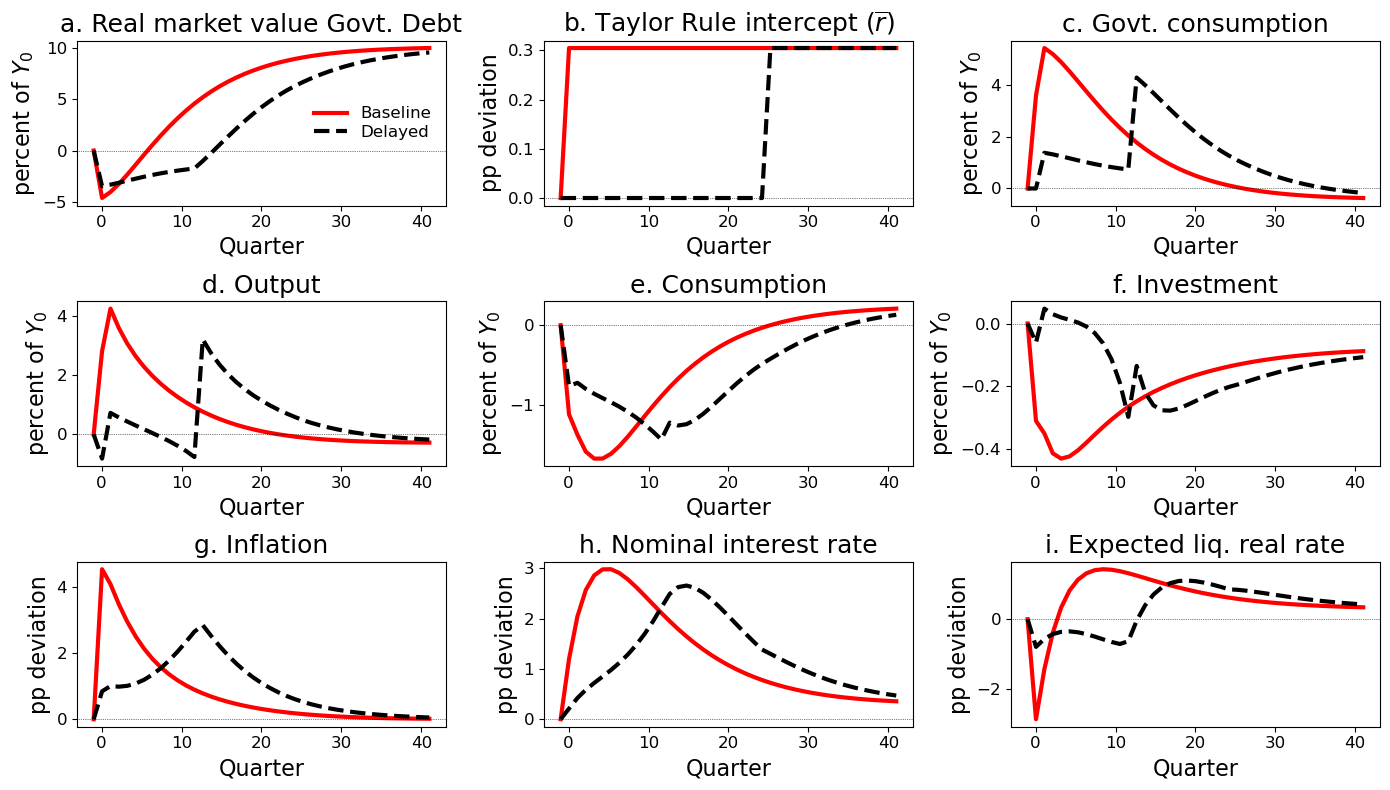

In [20]:
irf_hank_lb = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_lb_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'Delayed': irf_hank_lb}
plot_cases = ['Baseline', 'Delayed']
save_name = None
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [21]:
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_lb, open(os.path.join("irfs", "irf_delayed.json"), 'w'), cls=NumpyEncoder, indent=4)

In [22]:
welfare['Delayed'] = calculate_welfare(ss_hank_ini, ss_hank_end, irf_hank_lb_r)
welfare

{'Forward-looking': (np.float64(0.009515468931131643),
  np.float64(0.8002348627807798)),
 'Coincident': (np.float64(-0.05569040162084482),
  np.float64(0.8002348627807798)),
 'Delayed': (np.float64(-0.1616102459210289), np.float64(0.8002348627807798))}

## 4. Figure and Table

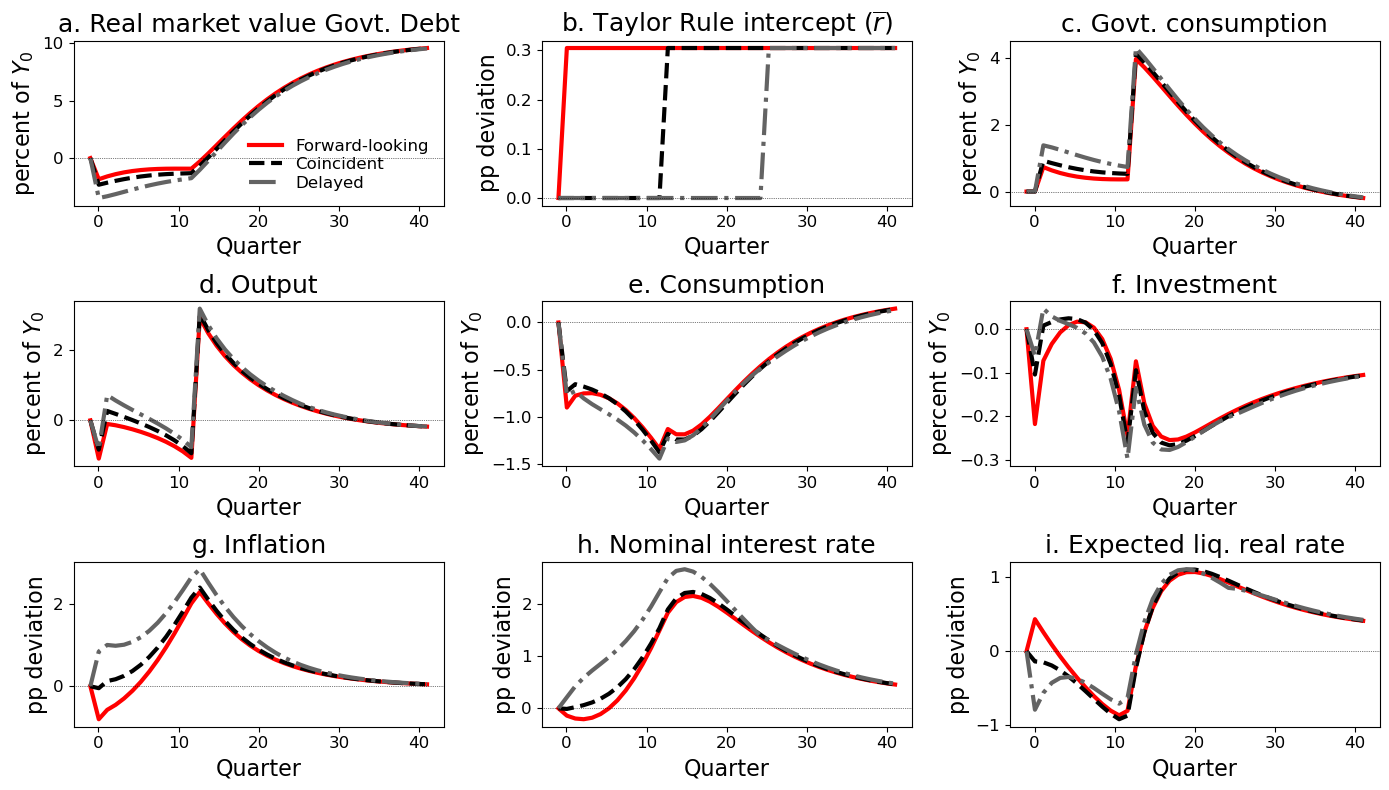

In [23]:
# Figure 7

irf_forward = json.load(open(os.path.join("irfs", "irf_forward.json")))
irf_forward = {k: np.array(v) for (k, v) in irf_forward.items()}

irf_coincident = json.load(open(os.path.join("irfs", "irf_coincident.json")))
irf_coincident = {k: np.array(v) for (k, v) in irf_coincident.items()}

irf_delayed = json.load(open(os.path.join("irfs", "irf_delayed.json")))
irf_delayed = {k: np.array(v) for (k, v) in irf_delayed.items()}

to_plot = {'Forward-looking': irf_forward, 'Coincident': irf_coincident, 'Delayed': irf_delayed}
plot_cases = ['Forward-looking', 'Coincident', 'Delayed']
save_name = os.path.join("results", "2HANK_timing.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [26]:
# Table 5

values = [welfare['Forward-looking'][0], welfare['Coincident'][0], welfare['Delayed'][0]]
df = pd.DataFrame({r'Welfare Gain/Loss (\%)': values}, index=['Forward-looking', 'Coincident', 'Delayed'])
s = df.to_latex(index=True, float_format="%.2f")
print(s)
with open(os.path.join('results', 'table_5.tex'), 'w') as tf:
     tf.write(s)
df

\begin{tabular}{lr}
\toprule
 & Welfare Gain/Loss (\%) \\
\midrule
Forward-looking & 0.01 \\
Coincident & -0.06 \\
Delayed & -0.16 \\
\bottomrule
\end{tabular}



,Welfare Gain/Loss (\%)
Forward-looking,0.009515
Coincident,-0.055690
Delayed,-0.161610
